# 1. Paste the class file here

In [10]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction import FeatureHasher
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from datetime import datetime

class HR_Data_Prep_Utility(object):
	"""HR_Data_Prep_Utility is used for preparing data for the ML"""

	def __init__(self, dataset, feature_col, target_col, fe_hashing_ratio):
		"""
		Initialize and builds the HR Dataset to be used in training a model
		
		Only the below features are supported
		['MarriedID', 'MaritalStatusID', 'GenderID', 'EmpStatusID', 'DeptID', 'PerfScoreID', 'PayRate', 'Termd', 'PositionID', 'State', 'DOB', 'CitizenDesc', 'HispanicLatino', 'RaceDesc', 'DateofHire', 'DateofTermination', 'ManagerName', 'RecruitmentSource', 'EngagementSurvey', 'EmpSatisfaction', 'SpecialProjectsCount', 'LastPerformanceReview_Date']

		:param dataset: pandas dataframe read from csv
		:param feature_col: column names of the features
		:param target_col: column name of the target
		"""
		super(HR_Data_Prep_Utility, self).__init__()
		self.emp_ds = dataset
		self.feature_col = feature_col
		self.target_col = target_col
		self.fe_hashing_ratio = fe_hashing_ratio
		self._cat_col = ['MarriedID', 'MaritalStatusID', 'GenderID','EmpStatusID', 'DeptID', 'Termd', 'PositionID','State', 'CitizenDesc', 'HispanicLatino', 'RaceDesc', 'ManagerName', 'RecruitmentSource']
		self._num_col = ['PayRate', 'PerfScoreID', 'Age', 'CurrentCmpyExp', 'EngagementSurvey', 'EmpSatisfaction','SpecialProjectsCount', 'DaysSinceLastRev']
		self._cat_col_onehot = ['MarriedID', 'MaritalStatusID', 'GenderID','EmpStatusID', 'Termd', 'CitizenDesc', 'HispanicLatino']
		self._cat_columns_feat_hash = ['DeptID', 'PositionID','State', 'RaceDesc', 'ManagerName', 'RecruitmentSource']


	def get_x_y_data(self):
		"""
		Description
		:param name: description
		:return: Description
		"""
		X, y = self._split_x_y(self.emp_ds)
		X = self._values_fix(X)
		X = self._add_features(X[self.feature_col])
		X = self._missing_values_fix(X)
		X = self._encode_category_features(X, reduction_ratio=self.fe_hashing_ratio)
		y = self._missing_values_fix(y)
		y = self._encode_category_features(y, reduction_ratio=self.fe_hashing_ratio)
		X = self._scale_data(X)
		return X, y


	def _fe_fill_missing_val(self, X, column_name, fe_type):
		"""
		Description
		:param name: description
		:return: Description
		"""
		if(fe_type is 'num'):
			X[column_name + '_missing'] =  np.zeros((len(X.index), 1))
			#X.iloc[(X.loc[X[column_name].isna() == True]).index, X.columns.get_loc(column_name + '_missing')] = 1
			X.loc[X[column_name].isna() == True, column_name + '_missing'] = 1
			#X.iloc[(X.loc[X[column_name].isna() == True]).index, X.columns.get_loc(column_name)] = 0
			X.loc[X[column_name].isna() == True, column_name] = 0
		elif(fe_type is 'str'):
			#X.iloc[(X.loc[X[column_name].isna() == True]).index, X.columns.get_loc(column_name)] = 'Missing'
			X.loc[X[column_name].isna() == True, column_name] = 'Missing'
		return X


	def _fe_category_feature_hashing(self, X, column_name, n_features):
		"""
		Description
		:param name: description
		:return: Description
		"""
		fh = FeatureHasher(n_features=n_features, input_type='string')
		x_features_arr = fh.fit_transform(X[column_name].astype('str')).toarray()
		column_names = np.array([])
		for i in range(n_features):
			column_names = np.append(column_names, column_name+'_'+str(i+1))
		return pd.concat([X, pd.DataFrame(x_features_arr, columns=column_names)], axis=1)


	def _fe_category_one_hot_encoder(self, X, column_name):
		"""
		Description
		:param name: description
		:return: Description
		"""
		x_features_arr = pd.get_dummies(X[column_name])
		x_features_arr.rename(columns=lambda x: column_name+'_' + str(x), inplace=True)
		return pd.concat([X, x_features_arr], axis=1)


	def _split_x_y(self, X):
		"""
		Description
		:param name: description
		:return: Description
		"""
		return X[self.feature_col], X[self.target_col]


	def _add_features(self, X):
		"""
		Description
		:param name: description
		:return: Description
		"""
		now = datetime.now()
		if set(['DateofHire','DateofTermination', 'Termd']).issubset(X.columns):
			X['DateofHire'] = pd.to_datetime(X['DateofHire'], format="%m/%d/%Y")
			X['DateofTermination'] = pd.to_datetime(X['DateofTermination'], format="%m/%d/%y")
			X.loc[X['Termd'] == 0, 'CurrentCmpyExp'] = X['DateofHire'].apply(lambda x: now.year - x.year)
			X.loc[X['Termd'] == 1, 'CurrentCmpyExp'] = (X['DateofTermination'] - X['DateofHire'])/np.timedelta64(1,'Y')
			X = X.drop(['DateofHire', 'DateofTermination'], axis=1)
		if 'LastPerformanceReview_Date' in X.columns:
			X['LastPerformanceReview_Date'] = pd.to_datetime(X['LastPerformanceReview_Date'], format="%m/%d/%Y")
			X['DaysSinceLastRev'] = X['LastPerformanceReview_Date'].apply(lambda x: (now - x).days)
			X = X.drop(['LastPerformanceReview_Date'], axis=1)
		if 'DOB' in X.columns:
			X['DOB'] = pd.to_datetime(X['DOB'], format="%d-%m-%Y")
			X['Age'] = X['DOB'].apply(lambda x: now.year - x.year)
			X = X.drop(['DOB'], axis=1)
		return X


	def _format_date_of_termination(self, X):
		"""
		Description
		:param name: description
		:return: Description
		"""
		pattern1_match = X['DateofTermination'].str.match(pat = '^(0[1-9]|1[012])/(0[1-9]|1[0-9]|2[0-9]|3[01])/([0-9]{2})$')
		dates_p1 = pd.to_datetime((X[pattern1_match==True])['DateofTermination'], format="%m/%d/%y")
		pattern2_match = X['DateofTermination'].str.match(pat = '^((19|2[0-9])[0-9]{2})/(0[1-9]|1[012])/(0[1-9]|[12][0-9]|3[01])$')
		dates_p2 = pd.to_datetime((X[pattern2_match==True])['DateofTermination'], format="%Y/%m/%d")
		combined_dates = dates_p1.append(dates_p2)
		X = X.drop(['DateofTermination'], axis=1)
		X.at[combined_dates.index, 'DateofTermination'] = combined_dates.values
		return X


	def _missing_values_fix(self, X):
		"""
		Description
		:param name: description
		:return: Description
		"""
		#Added features are missed from this.. 
		cat_columns = list(set(self.feature_col) & set(self._cat_col))
		num_columns = list(set(self.feature_col) & set(self._num_col)) + ['CurrentCmpyExp', 'DaysSinceLastRev', 'Age']
		for column in cat_columns:
			if column in X.columns:
				X = self._fe_fill_missing_val(X, column, 'str')
		for column in num_columns:
			if column in X.columns:
				X = self._fe_fill_missing_val(X, column, 'num')
		return X


	def _values_fix(self, X):
		"""
		Description
		:param name: description
		:return: Description
		"""
		if 'HispanicLatino' in X.columns:
			X.loc[X['HispanicLatino']=='yes', 'HispanicLatino'] = 'Yes'
			X.loc[X['HispanicLatino']=='no', 'HispanicLatino'] = 'No'
		return X


	def _encode_category_features(self, X, reduction_ratio):
		"""
		Description
		:param name: description
		:return: Description
		"""
		cat_columns_oh = list(set(self.feature_col) & set(self._cat_col_onehot))
		cat_columns_fh = list(set(self.feature_col) & set(self._cat_columns_feat_hash))
		for column in cat_columns_oh:
			if column in X.columns:
				X = self._fe_category_one_hot_encoder(X, column)
		for column in cat_columns_fh:
			if column in X.columns:
				#X = self._fe_category_feature_hashing(X, column, int(len(X[column].unique())*reduction_ratio))
				X = self._fe_category_one_hot_encoder(X, column)
		drop_encoded_fe = []
		for column in cat_columns_oh + cat_columns_fh:
			if column in X.columns:
				drop_encoded_fe.append(column)
		X = X.drop(drop_encoded_fe, axis=1)
		return X


	def _scale_data(self, X):
		"""
		Description
		:param name: description
		:return: Description
		"""
		scaler = StandardScaler()
		scaler.fit(X)
		return pd.DataFrame(scaler.transform(X), columns=X.columns)

# Read the csv file.. 
if it is in local, follow below, if it is google colab, follow 2nd method given by Nusrath

In [11]:
emp_ds_l = pd.read_csv('HRDataset_v13.csv')

# prepare two lists
One - which columns are going to be your X features
two - which columns are going to be your y feaute (only one)
Create a object for the class intializing these

In [45]:
x_features = ['MarriedID', 'MaritalStatusID', 'GenderID','EmpStatusID', 'DeptID', 'PayRate', 'Termd', 'PositionID','State', 'DOB', 'CitizenDesc', 'HispanicLatino', 'RaceDesc', 'DateofHire', 'DateofTermination','ManagerName', 'RecruitmentSource', 'EngagementSurvey', 'EmpSatisfaction','SpecialProjectsCount', 'LastPerformanceReview_Date']
y_features = ['PerfScoreID']
hr_prep = HR_Data_Prep_Utility(emp_ds_l, x_features, y_features, 0.5)

# Call get_x_y_data method
you will get your X and y to use and train your model

In [46]:
X, y = hr_prep.get_x_y_data()

C:\Users\gkailasam\AppData\Local\Continuum\anaconda3_1\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [47]:
X

,PayRate,EngagementSurvey,EmpSatisfaction,SpecialProjectsCount,CurrentCmpyExp,DaysSinceLastRev,Age,EngagementSurvey_missing,EmpSatisfaction_missing,SpecialProjectsCount_missing,...,ManagerName_Jennifer Zamora,ManagerName_John Smith,ManagerName_Kelley Spirea,ManagerName_Ketsia Liebig,ManagerName_Kissy Sullivan,ManagerName_Lynn Daneault,ManagerName_Michael Albert,ManagerName_Peter Monroe,ManagerName_Simon Roup,ManagerName_Webster Butler
0,-0.181317,-1.002786,-2.079060,2.039987,2.356114,0.784284,-0.953088,0.0,0.0,0.0,...,-0.151994,-0.217479,-0.276385,-0.269563,-0.276385,-0.209215,-0.276385,-0.217479,-0.240874,-0.269563
1,-0.539418,1.294446,0.120628,1.188275,0.268304,0.773321,-0.614261,0.0,0.0,0.0,...,-0.151994,-0.217479,-0.276385,-0.269563,-0.276385,-0.209215,-0.276385,-0.217479,-0.240874,-0.269563
2,-0.148762,0.440745,1.220472,1.614131,0.268304,0.767839,-0.840145,0.0,0.0,0.0,...,-0.151994,-0.217479,-0.276385,-0.269563,-0.276385,-0.209215,-0.276385,-0.217479,-0.240874,-0.269563
3,-0.637082,-0.071476,-0.979216,1.188275,-1.764249,-1.413811,-0.727203,0.0,0.0,0.0,...,-0.151994,-0.217479,-0.276385,-0.269563,-0.276385,-0.209215,-0.276385,-0.217479,-0.240874,-0.269563
4,-0.958722,1.294446,-0.979216,1.614131,-0.079664,0.784284,-1.066030,0.0,0.0,0.0,...,-0.151994,-0.217479,-0.276385,-0.269563,-0.276385,-0.209215,-0.276385,-0.217479,-0.240874,-0.269563
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
305,1.485482,-1.383071,1.220472,2.891699,0.268304,0.630801,2.999895,0.0,0.0,0.0,...,-0.151994,-0.217479,-0.276385,-0.269563,-0.276385,-0.209215,-0.276385,4.598136,-0.240874,-0.269563
306,1.622211,0.875357,1.220472,2.039987,0.268304,0.828136,-0.840145,0.0,0.0,0.0,...,-0.151994,-0.217479,-0.276385,-0.269563,-0.276385,-0.209215,-0.276385,4.598136,-0.240874,-0.269563
307,1.465949,-0.048193,0.120628,1.614131,-0.427632,0.789765,-0.501318,0.0,0.0,0.0,...,-0.151994,-0.217479,-0.276385,-0.269563,-0.276385,-0.209215,-0.276385,4.598136,-0.240874,-0.269563
308,1.413862,1.294446,-0.979216,1.188275,0.268304,0.855544,1.531644,0.0,0.0,0.0,...,-0.151994,-0.217479,-0.276385,-0.269563,-0.276385,-0.209215,-0.276385,4.598136,-0.240874,-0.269563


In [19]:
from sklearn.preprocessing import PolynomialFeatures
poly_features = PolynomialFeatures(degree = 2, include_bias=False)
# X_poly = poly_features.fit_transform(X)
# X = X_poly
# Unable to allocate 148. GiB for an array with shape (310, 64133474) and data type float64
# Forcing polynomial features does not work because of burst in features 64133474

In [39]:
## For plotting learning curve

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

def plot_learning_curves(model, X, y):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)
    y_train = y_train.to_numpy().reshape((len(y_train),))
    y_val = y_val.to_numpy().reshape((len(y_val),))
    train_errors, val_errors = [], []
    for m in range(1, len(X_train)):
        model.fit(X_train[:m], y_train[:m])
        y_train_predict = model.predict(X_train[:m])
        y_val_predict = model.predict(X_val)
        train_errors.append(mean_squared_error(y_train[:m], y_train_predict))
        val_errors.append(mean_squared_error(y_val, y_val_predict))
    plt.plot(np.sqrt(train_errors), "r-+", linewidth=2, label="train")
    plt.plot(np.sqrt(val_errors), "b-", linewidth=3, label="val")

In [49]:
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV

#sss = StratifiedShuffleSplit(n_splits=5, test_size=0.3, random_state=0)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
y_train = y_train.to_numpy().reshape((len(y_train),))

In [50]:
from sklearn.linear_model import SGDRegressor

lreg = SGDRegressor(max_iter=1000, tol=1e-3, random_state=1)

from sklearn.model_selection import cross_val_score

scores = cross_val_score(lreg, X_train, y_train, cv = 10, scoring='neg_mean_squared_error')

In [51]:
print("Score: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Score: -3.16 (+/- 3.03)


In [43]:
scores

array([-1.29522796e+25, -2.80905227e+25, -1.25004638e+26, -6.68981858e+25,
       -8.67586932e+26, -1.53002607e+26, -1.68366048e+26, -1.02082109e+26,
       -1.52677723e+25, -2.85135336e+25])

In [35]:
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor

pipelines = []
pipelines.append(('ScaledLR', Pipeline([('LR',LinearRegression())])))
pipelines.append(('ScaledLASSO', Pipeline([('LASSO', Lasso())])))
pipelines.append(('ScaledEN', Pipeline([('EN', ElasticNet())])))
pipelines.append(('ScaledKNN', Pipeline([('KNN', KNeighborsRegressor())])))
pipelines.append(('ScaledCART', Pipeline([('CART', DecisionTreeRegressor())])))
pipelines.append(('ScaledGBM', Pipeline([('GBM', GradientBoostingRegressor())])))

In [36]:
results = []
names = []
for name, model in pipelines:
    kfold = KFold(n_splits=10, random_state=21)
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring='neg_mean_squared_error')
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

ScaledLR: -0.477757 (0.138470)
ScaledLASSO: -0.362863 (0.154623)
ScaledEN: -0.362771 (0.153842)
ScaledKNN: -0.372448 (0.156078)
ScaledCART: -0.515714 (0.183254)
ScaledGBM: -0.324329 (0.106307)


In [37]:
from sklearn.model_selection import GridSearchCV

scaler = StandardScaler().fit(X_train)
rescaledX = scaler.transform(X_train)
param_grid = dict(n_estimators=np.array([8, 9, 10, 14, 15, 16]))
model = GradientBoostingRegressor(random_state=21)
kfold = KFold(n_splits=10, random_state=21)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring='neg_mean_squared_error', cv=kfold)
grid_result = grid.fit(rescaledX, y_train)

means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

C:\Users\gkailasam\AppData\Local\Continuum\anaconda3_1\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


-0.273871 (0.104955) with: {'n_estimators': 8}
-0.272147 (0.105793) with: {'n_estimators': 9}
-0.275463 (0.110565) with: {'n_estimators': 10}
-0.277931 (0.109855) with: {'n_estimators': 14}
-0.277311 (0.107666) with: {'n_estimators': 15}
-0.275964 (0.107831) with: {'n_estimators': 16}
Best: -0.272147 using {'n_estimators': 9}


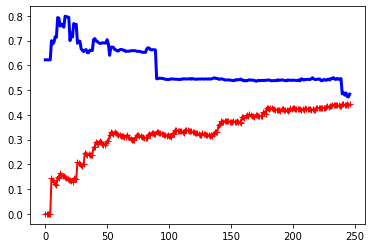

In [40]:
plot_learning_curves(grid.best_estimator_, X, y)

In [111]:
y_test_pred = grid.best_estimator_.predict(X_test)

In [112]:
from sklearn.metrics import mean_squared_error
scores = mean_squared_error(y_test, y_test_pred)
scores

0.2604828430465249

In [113]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import SGDRegressor

param_grid = {'eta0':(0.015, 0.016, 0.017, 0.018, 0.019), 'max_iter':[1000, 1500, 2000]}
model = SGDRegressor(tol=1e-3)
kfold = KFold(n_splits=10, random_state=21)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring='neg_mean_squared_error', cv=kfold)

grid_result = grid.fit(X_train, y_train)

means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

-3.156921 (1.491833) with: {'eta0': 0.015, 'max_iter': 1000}
-3.115024 (1.461111) with: {'eta0': 0.015, 'max_iter': 1500}
-3.128986 (1.457429) with: {'eta0': 0.015, 'max_iter': 2000}
-3.075061 (1.563985) with: {'eta0': 0.016, 'max_iter': 1000}
-3.108772 (1.442965) with: {'eta0': 0.016, 'max_iter': 1500}
-3.243232 (1.729707) with: {'eta0': 0.016, 'max_iter': 2000}
-3.495156 (1.758911) with: {'eta0': 0.017, 'max_iter': 1000}
-3.590766 (2.108409) with: {'eta0': 0.017, 'max_iter': 1500}
-4.060653 (2.243668) with: {'eta0': 0.017, 'max_iter': 2000}
-4.043611 (1.951130) with: {'eta0': 0.018, 'max_iter': 1000}
-4.942245 (2.484810) with: {'eta0': 0.018, 'max_iter': 1500}
-3.877996 (1.576790) with: {'eta0': 0.018, 'max_iter': 2000}
-5.642990 (3.720723) with: {'eta0': 0.019, 'max_iter': 1000}
-6.201649 (2.781963) with: {'eta0': 0.019, 'max_iter': 1500}
-6.118042 (4.560547) with: {'eta0': 0.019, 'max_iter': 2000}
Best: -3.075061 using {'eta0': 0.016, 'max_iter': 1000}


C:\Users\gkailasam\AppData\Local\Continuum\anaconda3_1\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
